# Wicklow mapping

In [108]:
import pandas as pd
import geopandas as gpd
import json
import matplotlib as mpl
import pylab as plt

from bokeh.io import output_file, show, output_notebook, export_png
from bokeh.models import ColumnDataSource, GeoJSONDataSource, LinearColorMapper, ColorBar, HoverTool
from bokeh.tile_providers import get_provider, Vendors
from bokeh.plotting import figure
from bokeh.palettes import brewer

import panel as pn
import panel.widgets as pnw
pn.extension()
output_notebook()

Loading BokehJS ...

In [2]:
def get_geodatasource(gdf):    
    """Get getjsondatasource from geopandas object"""
    json_data = json.dumps(json.loads(gdf.to_json()))
    return GeoJSONDataSource(geojson = json_data)

In [85]:
gdf = gpd.read_file('data/wicklow/2019_LEA_Boundaries.shp')
gdf=gdf.to_crs("EPSG:3395")

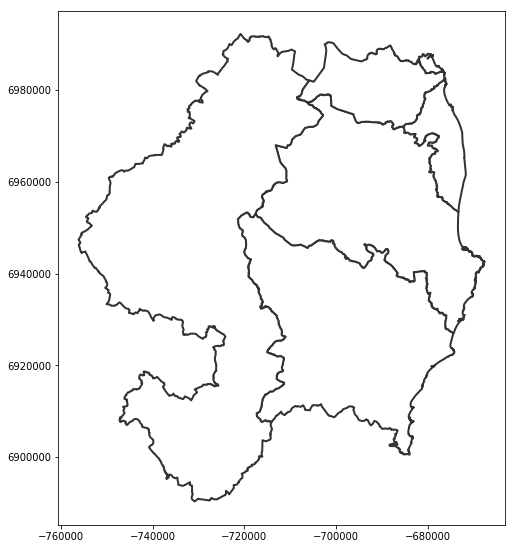

In [88]:
fig, ax = plt.subplots(1, figsize=(8,12))
gdf.plot(linewidth=0.8, ax=ax, edgecolor='0.2',legend=True, color='white', lw=2)

In [103]:
gsi = gpd.read_file('data/wicklow/GSI_Wicklow_CGS.shp')
gsi = gsi.to_crs("EPSG:3395")
gsi[:3]

OBJECTID SITECODE           SITENAME   IGH1  IGH2  IGH3  IGH4   COUNTY  \
0       126    WW048    Mullaghcleevaun   IGH7  None  None  None  Wicklow   
1       128    WW003    Avoca - Connary  IGH15  None  None  None  Wicklow   
2       129    WW004  Avoca - Cronebane  IGH15  None  None  None  Wicklow   

                                            DESCRIPT  \
0  The site comprises eroded peatland, exposed gr...   
1  Connary mine site is on high ground surrounded...   
2    Cronebane is centred on cronebane open mine pit   

                                          GEOLOGICAL  \
0  An excellent site for observing the results of...   
1  Mining last took place in Connary in the 19th ...   
2  The site covers the area of the 19th-century C...   

                                     DESIGNAT  \
0                                         CGS   
1  CGS, may be recommended for Geological NHA   
2  CGS, may be recommended for Geological NHA   

                                              REPORT    Y_IG    X_IG  \
0  https://secure.dccae.gov.ie/GSI_DOWNLOAD/Geohe...  206321  307304   
1  https://secure.dccae.gov.ie/GSI_DOWNLOAD/Geohe...  183849  321122   
2  https://secure.dccae.gov.ie/GSI_DOWNLOAD/Geohe...  183116  320680   

        Y_ITM       X_ITM    SHAPE_AREA     SHAPE_LEN  \
0  706353.466  707231.639  7.090403e+06  14024.394591   
1  683886.245  721045.793  5.285859e+04   1372.377167   
2  683153.492  720604.157  1.573151e+05   2562.449810   

                                            geometry  
0  POLYGON ((-709752.588 6969176.261, -709688.784...  
1  POLYGON ((-690079.196 6929103.111, -690095.388...  
2  POLYGON ((-691650.665 6927058.014, -691643.919...

In [173]:
def bokeh_plot_map(geosources, colors, columns=None, title='', plot_width=500):
    """Plot bokeh map from GeoJSONDataSources """
    
    palette = brewer['OrRd'][8]
    palette = palette[::-1]    
    tools = 'wheel_zoom,pan,reset'
    p = figure(title = title, plot_height=500 , plot_width=plot_width, toolbar_location='right', tools=tools)
    i=0
    for src in geosources:
        l=p.patches('xs','ys', source=src, fill_alpha=1, line_width=1, line_color='black', 
                  fill_color=colors[i])
        if columns == None:
            continue
        cols = columns[i]
        if cols != None:
            x = [(i, "@%s" %i) for i in cols]    
            hover = HoverTool(tooltips=x, point_policy='follow_mouse', renderers=[l])        
            #l.hover.tooltips = hover
            p.add_tools(hover)
        i+=1
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    p.toolbar.logo = None
    return p

In [174]:
gsrc1 = get_geodatasource(gdf)
gsrc2 = get_geodatasource(gsi)
p = bokeh_plot_map([gsrc1,gsrc2], colors=['whitesmoke','green'], columns=[None,['SITENAME','DESCRIPT']])

## Panel dashboard overlaying datasets on a single map

In [175]:
dataset_grp = pn.widgets.CheckBoxGroup(
    name='Dataset', value=['Outline','GSI'], options=['Outline', 'GSI'],
    inline=True)
dataframes = {'Outline':gdf,'GSI':gsi}
columns = {'Outline':None, 'GSI':['SITENAME','DESCRIPT']}
def replot(event):
    sources=[]
    cols=[]
    for i in dataset_grp.value:
        print (i)
        sources.append(get_geodatasource(dataframes[i]))
        cols.append(columns[i])
    print (sources)
    plot_pane.object = bokeh_plot_map(sources,colors=['whitesmoke','green'],columns=cols)
    return

dataset_grp.param.watch(replot,'value')
plot_pane = pn.pane.Bokeh(p)
app = pn.Column(dataset_grp,plot_pane)

In [176]:
app

Column
    [0] CheckBoxGroup(inline=True, name='Dataset', options=['Outline', 'GSI'], value=['Outline', 'GSI'])
    [1] Bokeh(Figure)